# Tree Graph Algorithm: From tskit Tables to Renderable Coordinates

This notebook explains the complete pipeline for converting a tskit tree sequence into a renderable graph structure. The algorithm takes edges and nodes tables plus a tree index and produces x,y coordinates suitable for visualization.

## Overview

The pipeline consists of these key steps:

1. **Load tree sequence** - Read the `.trees` file using tskit
2. **Edge filtering** - Find edges active at a specific genomic position
3. **Build parent array** - Map each node to its parent
4. **Build CSR children structure** - Compressed Sparse Row format for efficient traversal
5. **Compute Y coordinate** - Normalize node times to [0,1]
6. **Compute X coordinate** - Post-order traversal for layout positioning
7. **Serialize to PyArrow** - Binary format for network transfer

## Cell 1: Dependencies & Setup

In [53]:
import numpy as np
import tskit
import tszip
import pyarrow as pa
from numba import njit
from dataclasses import dataclass
from typing import Optional
import matplotlib.pyplot as plt

# Set display options for better array printing
np.set_printoptions(threshold=20, edgeitems=5)

## Cell 2: Load Tree Sequence

A tree sequence is a compact representation of genetic ancestry. It stores:
- **Nodes**: Individual ancestors or samples with associated times
- **Edges**: Parent-child relationships that span genomic intervals
- **Trees**: The set of edges active at each genomic position forms a tree

Modify the path below to point to your `.trees` or `.tsz` file:

In [54]:
# Modify this path to your tree sequence file
TREE_FILE = "../../../UPLOADS/test/slimquant2.trees"

# Load the tree sequence
ts = tskit.load(TREE_FILE)

# Print basic statistics
print(f"Tree Sequence Statistics:")
print(f"  Number of trees: {ts.num_trees:,}")
print(f"  Number of nodes: {ts.num_nodes:,}")
print(f"  Number of edges: {ts.num_edges:,}")
print(f"  Number of samples: {ts.num_samples:,}")
print(f"  Sequence length: {ts.sequence_length:,.0f} bp")
print(f"  Time range: [{ts.min_time:.2f}, {ts.max_time:.2f}]")
print(f"")
print(f"Breakpoints (first 10):")
breakpoints = list(ts.breakpoints())
print(f"  {breakpoints[:10]}")
if len(breakpoints) > 10:
    print(f"  ... and {len(breakpoints) - 10} more")

Tree Sequence Statistics:
  Number of trees: 17
  Number of nodes: 176
  Number of edges: 217
  Number of samples: 80
  Sequence length: 100,001 bp
  Time range: [0.00, 20000.00]

Breakpoints (first 10):
  [0.0, 1729.0, 7927.0, 10437.0, 18458.0, 19862.0, 20979.0, 35291.0, 35907.0, 37593.0]
  ... and 8 more


In [55]:
ts_h = tszip.load("../UPLOADS/Uploads/1kg_chr22.trees.tsz")

## Cell 3: Explore the Tables (Edges & Nodes)

The tskit tables contain the raw data we need:

### Edges Table
Each edge represents a parent-child relationship over a genomic interval:
- `left`: Start of the genomic interval (inclusive)
- `right`: End of the genomic interval (exclusive)
- `parent`: Parent node ID
- `child`: Child node ID

### Nodes Table
Each node represents an ancestor or sample:
- `time`: When this node existed (0 = present, larger = older)
- `flags`: Bit flags (1 = sample node)

In [56]:
edges = ts.tables.edges
nodes = ts.tables.nodes

print("=== EDGES TABLE ===")
print(f"Total edges: {len(edges)}")
print(f"")
print(f"First 10 edges:")
print(f"{'left':>12} {'right':>12} {'parent':>8} {'child':>8}")
print("-" * 44)
for i in range(min(10, len(edges))):
    print(f"{edges.left[i]:>12.1f} {edges.right[i]:>12.1f} {edges.parent[i]:>8} {edges.child[i]:>8}")

print(f"")
print("=== NODES TABLE ===")
print(f"Total nodes: {len(nodes)}")
print(f"")
print(f"First 10 nodes:")
print(f"{'node_id':>8} {'time':>12} {'flags':>6} {'is_sample':>10}")
print("-" * 40)
for i in range(min(10, len(nodes))):
    is_sample = "Yes" if nodes.flags[i] & 1 else "No"
    print(f"{i:>8} {nodes.time[i]:>12.4f} {nodes.flags[i]:>6} {is_sample:>10}")

=== EDGES TABLE ===
Total edges: 217

First 10 edges:
        left        right   parent    child
--------------------------------------------
         0.0     100001.0       94      104
         0.0     100001.0       94      113
         0.0     100001.0       95      108
         0.0     100001.0       95      154
         0.0     100001.0       93      109
         0.0     100001.0       93      129
         0.0     100001.0       92      116
         0.0     100001.0       92      138
         0.0     100001.0       91      101
         0.0     100001.0       91      127

=== NODES TABLE ===
Total nodes: 176

First 10 nodes:
 node_id         time  flags  is_sample
----------------------------------------
       0   20000.0000      0         No
       1   20000.0000      0         No
       2   20000.0000      0         No
       3    4619.0000      0         No
       4    2757.0000      0         No
       5    2641.0000      0         No
       6    1777.0000      0         No
 

## Cell 4: Edge Filtering for a Single Tree

**Key algorithm step**: For a tree at index `idx`, we need to find which edges are "active" at that tree's genomic position.

An edge is active if its interval contains the tree's left breakpoint:
```
edge.left <= breakpoint[idx] < edge.right
```

This is because trees are defined by the edges that span each genomic interval. The `breakpoints` array gives us the boundaries between trees.

In [57]:
# Choose which tree to visualize
tree_idx = 0

# Get the left boundary of this tree's interval
interval_left = breakpoints[tree_idx]
interval_right = breakpoints[tree_idx + 1]

print(f"Tree {tree_idx} spans genomic interval: [{interval_left:.1f}, {interval_right:.1f})")
print(f"")

# Filter edges: find edges where left <= interval_left < right
active_mask = (edges.left <= interval_left) & (edges.right > interval_left)
active_parents = edges.parent[active_mask]
active_children = edges.child[active_mask]

print(f"Active edges for tree {tree_idx}: {np.sum(active_mask)} (out of {len(edges)} total)")
print(f"")
print(f"First 10 active edges:")
print(f"{'parent':>8} {'child':>8}")
print("-" * 18)
for i in range(min(10, len(active_parents))):
    print(f"{active_parents[i]:>8} {active_children[i]:>8}")

print(f"")
print(f"Unique nodes in tree: {len(set(active_parents) | set(active_children))}")

Tree 0 spans genomic interval: [0.0, 1729.0)

Active edges for tree 0: 158 (out of 217 total)

First 10 active edges:
  parent    child
------------------
      94      104
      94      113
      95      108
      95      154
      93      109
      93      129
      92      116
      92      138
      91      101
      91      127

Unique nodes in tree: 160


## Cell 5: Build Parent Array

The parent array provides O(1) lookup: `parent[child_id] = parent_id`

- A value of `-1` means "no parent" (i.e., this node is a root or not in the tree)
- We initialize all values to `-1` and then fill in from active edges

In [58]:
num_nodes = len(nodes.time)

# Initialize parent array: -1 means "no parent"
parent = np.full(num_nodes, -1, dtype=np.int32)

# Fill in parent relationships from active edges
# parent[child] = parent_node
parent[active_children] = active_parents

print(f"Parent array shape: {parent.shape}")
print(f"")

# Track which nodes are in this tree
in_tree = np.zeros(num_nodes, dtype=np.bool_)
in_tree[active_children] = True
in_tree[active_parents] = True

# Find roots: nodes in the tree with no parent
roots = np.where(in_tree & (parent == -1))[0]

print(f"Nodes in tree: {np.sum(in_tree)}")
print(f"Root nodes: {roots}")
print(f"")

# Show parent array for first 10 in-tree nodes
in_tree_indices = np.where(in_tree)[0][:10]
print(f"Sample parent lookups (first 10 in-tree nodes):")
print(f"{'node_id':>8} {'parent':>8}")
print("-" * 18)
for node_id in in_tree_indices:
    print(f"{node_id:>8} {parent[node_id]:>8}")

Parent array shape: (176,)

Nodes in tree: 160
Root nodes: [0 2]

Sample parent lookups (first 10 in-tree nodes):
 node_id   parent
------------------
       0       -1
       2       -1
       4        2
       7        4
       9        7
      11        9
      13        9
      14       13
      15       14
      16       15


## Cell 6: Build CSR Children Structure

**Compressed Sparse Row (CSR)** format is an efficient way to store the children of each node.

CSR uses two arrays:
- `children_indptr`: Row pointers (length = num_nodes + 1)
- `children_data`: Flattened array of all children

To get children of node `n`:
```python
children = children_data[children_indptr[n]:children_indptr[n+1]]
```

This gives O(1) access to any node's children without Python lists.

In [59]:
# Step 1: Count children for each parent
child_counts = np.bincount(active_parents, minlength=num_nodes).astype(np.int32)

# Step 2: Build indptr as cumulative sum of counts
children_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
children_indptr[1:] = np.cumsum(child_counts)

# Step 3: Sort children by parent to create contiguous blocks
sort_idx = np.argsort(active_parents, kind='stable')
children_data = active_children[sort_idx].astype(np.int32)

print(f"CSR Structure:")
print(f"  children_indptr shape: {children_indptr.shape}")
print(f"  children_data shape: {children_data.shape}")
print(f"")

# Helper function to get children
def get_children(node_id):
    return children_data[children_indptr[node_id]:children_indptr[node_id + 1]]

def is_tip(node_id):
    return children_indptr[node_id + 1] == children_indptr[node_id]

# Demonstrate CSR lookups
print("CSR Lookups (nodes with children):")
print(f"{'node_id':>8} {'num_children':>12} {'children':>20}")
print("-" * 44)
shown = 0
for node_id in in_tree_indices:
    children = get_children(node_id)
    if len(children) > 0:
        print(f"{node_id:>8} {len(children):>12} {str(list(children)):>20}")
        shown += 1
        if shown >= 5:
            break

# Count tips
num_tips = sum(1 for n in np.where(in_tree)[0] if is_tip(n))
print(f"")
print(f"Total tips (leaf nodes): {num_tips}")

CSR Structure:
  children_indptr shape: (177,)
  children_data shape: (158,)

CSR Lookups (nodes with children):
 node_id num_children             children
--------------------------------------------
       0            1      [np.int32(135)]
       2            1        [np.int32(4)]
       4            2 [np.int32(7), np.int32(20)]
       7            2 [np.int32(9), np.int32(18)]
       9            2 [np.int32(11), np.int32(13)]

Total tips (leaf nodes): 80


## Cell 7: Compute Y Coordinate (Normalized Time)

The Y coordinate maps node times to the [0, 1] range.

We invert the time so that:
- Root (oldest, max_time) -> y = 0 (top/left of tree)
- Tips (youngest, min_time) -> y = 1 (bottom/right of tree)

Formula:
```python
y = (max_time - node_time) / (max_time - min_time)
```

In [60]:
node_times = nodes.time
min_time = ts.min_time
max_time = ts.max_time

print(f"Time range: [{min_time:.4f}, {max_time:.4f}]")
print(f"")

# Compute normalized Y coordinate (vectorized)
time_range = max_time - min_time if max_time > min_time else 1.0
y = ((max_time - node_times) / time_range).astype(np.float32)

print(f"Y coordinates (time-based):")
print(f"{'node_id':>8} {'time':>12} {'y':>8}")
print("-" * 32)

# Show roots and tips
for node_id in roots:
    print(f"{node_id:>8} {node_times[node_id]:>12.4f} {y[node_id]:>8.4f}  <- ROOT")

print("...")

# Show some tips
tips = [n for n in np.where(in_tree)[0] if is_tip(n)][:3]
for node_id in tips:
    print(f"{node_id:>8} {node_times[node_id]:>12.4f} {y[node_id]:>8.4f}  <- TIP")

Time range: [0.0000, 20000.0000]

Y coordinates (time-based):
 node_id         time        y
--------------------------------
       0   20000.0000   0.0000  <- ROOT
       2   20000.0000   0.0000  <- ROOT
...
      96       0.0000   1.0000  <- TIP
      97       0.0000   1.0000  <- TIP
      98       0.0000   1.0000  <- TIP


## Cell 8: Compute X Coordinate (Post-Order Traversal) - CORE ALGORITHM

The X coordinate determines the horizontal position of each node. We use **post-order traversal**:

1. Visit all children first (post-order)
2. Tips get sequential x values: 0, 1, 2, ...
3. Internal nodes get the average of their children's x values
4. Normalize to [0, 1] by dividing by (tip_count - 1)

This creates a layout where:
- Tips are evenly spaced
- Parents are centered above their children

### Why Stack-Based?
We use an iterative stack-based approach instead of recursion to:
- Avoid Python's recursion limit (default ~1000)
- Enable Numba JIT compilation for speed
- Handle very deep trees efficiently

In [61]:
# Pure Python version (slower but easier to understand)
def compute_x_python(children_indptr, children_data, roots, num_nodes, verbose=False):
    """
    Pure Python post-order traversal for computing x coordinates.
    Includes optional verbose output to trace the algorithm.
    """
    x = np.full(num_nodes, -1.0, dtype=np.float32)
    tip_counter = 0
    
    # Stack entries: (node, visited)
    # visited=False: first visit, push children
    # visited=True: children processed, compute x
    
    for root in roots:
        stack = [(root, False)]
        
        while stack:
            node, visited = stack.pop()
            
            # Get children using CSR lookup
            start = children_indptr[node]
            end = children_indptr[node + 1]
            children = children_data[start:end]
            
            if not visited and len(children) > 0:
                # First visit: push self as visited, then push children
                stack.append((node, True))
                for child in children:
                    stack.append((child, False))
                if verbose:
                    print(f"  Node {node}: pushed children {list(children)}")
            else:
                # Post-order processing
                if len(children) == 0:
                    # Tip: assign sequential x value
                    x[node] = tip_counter
                    if verbose:
                        print(f"  Node {node}: TIP -> x = {tip_counter}")
                    tip_counter += 1
                else:
                    # Internal: average of children's x values
                    children_x = [x[c] for c in children]
                    x[node] = sum(children_x) / len(children)
                    if verbose:
                        print(f"  Node {node}: INTERNAL, children_x={children_x} -> x = {x[node]:.2f}")
    
    return x, tip_counter

# Run with verbose output on a small example
print("=== Post-Order Traversal Trace ===")
print(f"Starting from roots: {roots}")
print(f"")

x_python, tip_count = compute_x_python(
    children_indptr, children_data, roots.astype(np.int32), num_nodes, 
    verbose=True
)

print(f"")
print(f"Tip count: {tip_count}")

=== Post-Order Traversal Trace ===
Starting from roots: [0 2]

  Node 0: pushed children [np.int32(135)]
  Node 135: TIP -> x = 0
  Node 0: INTERNAL, children_x=[np.float32(0.0)] -> x = 0.00
  Node 2: pushed children [np.int32(4)]
  Node 4: pushed children [np.int32(7), np.int32(20)]
  Node 20: pushed children [np.int32(21), np.int32(140)]
  Node 140: TIP -> x = 1
  Node 21: pushed children [np.int32(28), np.int32(75)]
  Node 75: pushed children [np.int32(93), np.int32(120)]
  Node 120: TIP -> x = 2
  Node 93: pushed children [np.int32(109), np.int32(129)]
  Node 129: TIP -> x = 3
  Node 109: TIP -> x = 4
  Node 93: INTERNAL, children_x=[np.float32(4.0), np.float32(3.0)] -> x = 3.50
  Node 75: INTERNAL, children_x=[np.float32(3.5), np.float32(2.0)] -> x = 2.75
  Node 28: pushed children [np.int32(34), np.int32(35)]
  Node 35: pushed children [np.int32(137), np.int32(144)]
  Node 144: TIP -> x = 5
  Node 137: TIP -> x = 6
  Node 35: INTERNAL, children_x=[np.float32(6.0), np.float32(5.0)

In [62]:
# Numba-optimized version (production code)
@njit(cache=True)
def _compute_x_postorder(children_indptr, children_data, roots, num_nodes):
    """
    Numba-compiled post-order traversal for computing x (layout) coordinates.
    
    Tips get sequential x values (0, 1, 2, ...), internal nodes get average of children.
    
    Args:
        children_indptr: CSR indptr array
        children_data: CSR data array (flattened children)
        roots: Array of root node IDs
        num_nodes: Total number of nodes
    
    Returns:
        (x, tip_counter): x coordinates array and number of tips
    """
    x = np.full(num_nodes, -1.0, dtype=np.float32)
    tip_counter = 0
    
    # Pre-allocated stack arrays (avoid Python list overhead)
    stack_nodes = np.empty(num_nodes, dtype=np.int32)
    stack_visited = np.empty(num_nodes, dtype=np.uint8)  # 0=False, 1=True
    
    for i in range(len(roots)):
        root = roots[i]
        stack_ptr = 0
        
        # Push root onto stack
        stack_nodes[stack_ptr] = root
        stack_visited[stack_ptr] = 0
        stack_ptr += 1
        
        while stack_ptr > 0:
            # Pop from stack
            stack_ptr -= 1
            node = stack_nodes[stack_ptr]
            visited = stack_visited[stack_ptr]
            
            # CSR lookup for children
            start = children_indptr[node]
            end = children_indptr[node + 1]
            num_children = end - start
            
            if visited == 0 and num_children > 0:
                # First visit: push node back as visited, then push children
                stack_nodes[stack_ptr] = node
                stack_visited[stack_ptr] = 1
                stack_ptr += 1
                
                # Push all children
                for j in range(start, end):
                    stack_nodes[stack_ptr] = children_data[j]
                    stack_visited[stack_ptr] = 0
                    stack_ptr += 1
            else:
                # Post-order processing
                if num_children == 0:
                    # Tip: sequential x value
                    x[node] = tip_counter
                    tip_counter += 1
                else:
                    # Internal: average of children (inline to avoid np.mean overhead)
                    total = 0.0
                    for j in range(start, end):
                        total += x[children_data[j]]
                    x[node] = total / num_children
    
    return x, tip_counter

# Run Numba version
x_numba, tip_count_numba = _compute_x_postorder(
    children_indptr, children_data, roots.astype(np.int32), num_nodes
)

# Verify both versions match
print("Comparing Python vs Numba implementations:")
print(f"  Tip counts: Python={tip_count}, Numba={tip_count_numba}")
matches = np.allclose(x_python[in_tree], x_numba[in_tree], atol=1e-6)
print(f"  X values match: {matches}")

Comparing Python vs Numba implementations:
  Tip counts: Python=80, Numba=80
  X values match: True


In [63]:
# Use the Numba result and normalize to [0, 1]
x = x_numba.copy()
if tip_count_numba > 1:
    x[in_tree] /= (tip_count_numba - 1)

print("Final X coordinates (normalized to [0, 1]):")
print(f"{'node_id':>8} {'x':>8} {'type':>10}")
print("-" * 28)

# Show some nodes
for node_id in np.where(in_tree)[0][:10]:
    node_type = "TIP" if is_tip(node_id) else "INTERNAL"
    if parent[node_id] == -1:
        node_type = "ROOT"
    print(f"{node_id:>8} {x[node_id]:>8.4f} {node_type:>10}")

Final X coordinates (normalized to [0, 1]):
 node_id        x       type
----------------------------
       0   0.0000       ROOT
       2   0.2519       ROOT
       4   0.2519   INTERNAL
       7   0.4683   INTERNAL
       9   0.7555   INTERNAL
      11   0.9652   INTERNAL
      13   0.5457   INTERNAL
      14   0.7014   INTERNAL
      15   0.8261   INTERNAL
      16   0.8422   INTERNAL


## Cell 9: TreeGraph Dataclass

We package all computed data into a dataclass for clean organization:

In [64]:
@dataclass
class TreeGraph:
    """
    Graph representation using numpy arrays with CSR format for children.
    
    Attributes:
        parent: int32 array where parent[node_id] = parent_id (-1 for root)
        time: float32 array of raw node times
        children_indptr: int32 CSR row pointers (length = num_nodes + 1)
        children_data: int32 flattened children array
        x: float32 layout position [0,1] (tips spread, internal=avg of children)
        y: float32 normalized time [0,1] (max_time=0, min_time=1)
        in_tree: bool array indicating which nodes are in this tree
    """
    parent: np.ndarray
    time: np.ndarray
    children_indptr: np.ndarray
    children_data: np.ndarray
    x: np.ndarray
    y: np.ndarray
    in_tree: np.ndarray
    
    def children(self, node_id: int) -> np.ndarray:
        """Get children of a node as numpy array slice (zero-copy)."""
        return self.children_data[self.children_indptr[node_id]:self.children_indptr[node_id + 1]]
    
    def is_tip(self, node_id: int) -> bool:
        """Check if a node is a tip (no children)."""
        return self.children_indptr[node_id + 1] == self.children_indptr[node_id]

# Create TreeGraph from our computed arrays
graph = TreeGraph(
    parent=parent,
    time=node_times.astype(np.float32),
    children_indptr=children_indptr,
    children_data=children_data,
    x=x,
    y=y,
    in_tree=in_tree
)

print(f"TreeGraph created!")
print(f"  Nodes in tree: {np.sum(graph.in_tree)}")
print(f"  X range: [{graph.x[graph.in_tree].min():.4f}, {graph.x[graph.in_tree].max():.4f}]")
print(f"  Y range: [{graph.y[graph.in_tree].min():.4f}, {graph.y[graph.in_tree].max():.4f}]")

TreeGraph created!
  Nodes in tree: 160
  X range: [0.0000, 1.0000]
  Y range: [0.0000, 1.0000]


## Cell 10: Complete `construct_tree()` Function

Here's the full function that combines all steps. This is the production code used by the Lorax backend:

In [65]:
def construct_tree(
    ts,
    edges,
    nodes,
    breakpoints,
    index: int,
    min_time: Optional[float] = None,
    max_time: Optional[float] = None
) -> TreeGraph:
    """
    Construct tree with x,y coordinates using Numba-optimized post-order traversal.
    
    Args:
        ts: tskit TreeSequence object
        edges: ts.tables.edges (pre-extracted for reuse)
        nodes: ts.tables.nodes (pre-extracted for reuse)
        breakpoints: list/array of breakpoints (pre-extracted for reuse)
        index: Tree index
        min_time: Optional global min time (default: ts.min_time)
        max_time: Optional global max time (default: ts.max_time)
    
    Returns:
        TreeGraph with CSR children and x,y coordinates in [0,1].
    """
    if index < 0 or index >= ts.num_trees:
        raise ValueError(f"Tree index {index} out of range [0, {ts.num_trees - 1}]")
    
    interval_left = breakpoints[index]
    num_nodes = len(nodes.time)
    node_times = nodes.time
    
    # Use provided min/max or compute from ts
    if min_time is None:
        min_time = ts.min_time
    if max_time is None:
        max_time = ts.max_time
    
    # === Edge filtering & parent array ===
    active_mask = (edges.left <= interval_left) & (edges.right > interval_left)
    active_parents = edges.parent[active_mask]
    active_children = edges.child[active_mask]
    
    parent = np.full(num_nodes, -1, dtype=np.int32)
    parent[active_children] = active_parents
    
    # === CSR children structure ===
    child_counts = np.bincount(active_parents, minlength=num_nodes).astype(np.int32)
    children_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
    children_indptr[1:] = np.cumsum(child_counts)
    sort_idx = np.argsort(active_parents, kind='stable')
    children_data = active_children[sort_idx].astype(np.int32)
    
    # === Track which nodes are in this tree ===
    in_tree = np.zeros(num_nodes, dtype=np.bool_)
    in_tree[active_children] = True
    in_tree[active_parents] = True
    
    # === Y coordinate: normalized time (vectorized) ===
    time_range = max_time - min_time if max_time > min_time else 1.0
    y = ((max_time - node_times) / time_range).astype(np.float32)
    
    # === X coordinate: Numba-optimized post-order traversal ===
    roots = np.where(in_tree & (parent == -1))[0].astype(np.int32)
    x, tip_counter = _compute_x_postorder(children_indptr, children_data, roots, num_nodes)
    
    # Normalize x to [0, 1]
    if tip_counter > 1:
        x[in_tree] /= (tip_counter - 1)
    
    return TreeGraph(
        parent=parent,
        time=node_times.astype(np.float32),
        children_indptr=children_indptr,
        children_data=children_data,
        x=x,
        y=y,
        in_tree=in_tree
    )

## Cell 11: Run the Algorithm

In [66]:
# Choose which tree to visualize
tree_idx = 0

# Pre-extract tables for efficiency
edges = ts.tables.edges
nodes = ts.tables.nodes
breakpoints = list(ts.breakpoints())

# Construct the tree graph
graph = construct_tree(ts, edges, nodes, breakpoints, tree_idx)

print(f"Tree {tree_idx} constructed:")
print(f"  Nodes in tree: {np.sum(graph.in_tree)}")
print(f"  Tips: {sum(1 for n in np.where(graph.in_tree)[0] if graph.is_tip(n))}")
print(f"  Roots: {list(np.where(graph.in_tree & (graph.parent == -1))[0])}")
print(f"")
print(f"  X range: [{graph.x[graph.in_tree].min():.4f}, {graph.x[graph.in_tree].max():.4f}]")
print(f"  Y range: [{graph.y[graph.in_tree].min():.4f}, {graph.y[graph.in_tree].max():.4f}]")

Tree 0 constructed:
  Nodes in tree: 160
  Tips: 80
  Roots: [np.int64(0), np.int64(2)]

  X range: [0.0000, 1.0000]
  Y range: [0.0000, 1.0000]


## Cell 12: Visualize the Result

Let's plot the tree using matplotlib to verify the coordinates make sense:

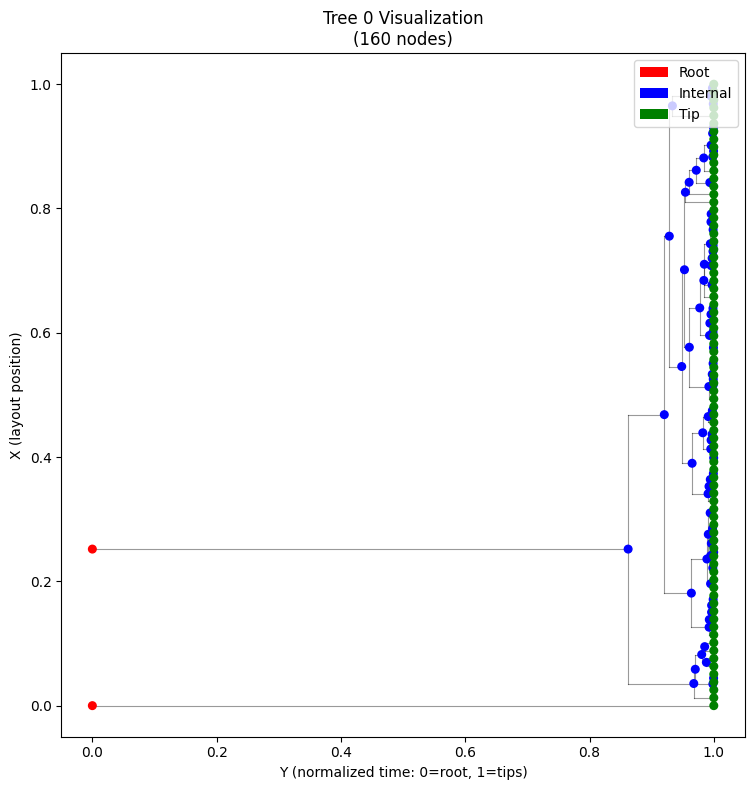

In [67]:
# Get nodes in tree
indices = np.where(graph.in_tree)[0]

# Prepare colors: tips = green, internal = blue, roots = red
colors = []
for i in indices:
    if graph.parent[i] == -1:
        colors.append('red')  # Root
    elif graph.is_tip(i):
        colors.append('green')  # Tip
    else:
        colors.append('blue')  # Internal

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Draw edges (parent-child lines)
for node in indices:
    if graph.parent[node] != -1:
        p = graph.parent[node]
        # Draw elbow connector: vertical then horizontal
        ax.plot([graph.y[node], graph.y[p]], [graph.x[node], graph.x[node]], 
                'k-', alpha=0.4, linewidth=0.8)
        ax.plot([graph.y[p], graph.y[p]], [graph.x[node], graph.x[p]], 
                'k-', alpha=0.4, linewidth=0.8)

# Draw nodes
ax.scatter(graph.y[indices], graph.x[indices], c=colors, s=30, zorder=5)

# Labels
ax.set_xlabel('Y (normalized time: 0=root, 1=tips)')
ax.set_ylabel('X (layout position)')
ax.set_title(f'Tree {tree_idx} Visualization\n({np.sum(graph.in_tree)} nodes)')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Root'),
    Patch(facecolor='blue', label='Internal'),
    Patch(facecolor='green', label='Tip')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## Cell 13: PyArrow Serialization

The frontend receives tree data via PyArrow IPC (Inter-Process Communication) format. This binary format is:
- **Efficient**: Zero-copy reads in JavaScript via Arrow.js
- **Compact**: Binary representation is smaller than JSON
- **Typed**: Schema guarantees correct data types

Note: We swap x and y coordinates for the backend convention:
- Backend x = time (our y)
- Backend y = layout (our x)

In [68]:
def to_pyarrow(graph: TreeGraph, tree_idx: int = 0) -> bytes:
    """
    Serialize TreeGraph to PyArrow IPC format for frontend rendering.
    
    Note: Coordinates are swapped to match backend convention:
    - Backend x = self.y (time)
    - Backend y = self.x (layout)
    
    Args:
        graph: TreeGraph instance
        tree_idx: Tree index to include in output
    
    Returns:
        bytes: PyArrow IPC binary data
    """
    # Get nodes that are in this tree
    indices = np.where(graph.in_tree)[0].astype(np.int32)
    n = len(indices)
    
    if n == 0:
        table = pa.table({
            'node_id': pa.array([], type=pa.int32()),
            'parent_id': pa.array([], type=pa.int32()),
            'is_tip': pa.array([], type=pa.bool_()),
            'tree_idx': pa.array([], type=pa.int32()),
            'x': pa.array([], type=pa.float32()),
            'y': pa.array([], type=pa.float32()),
        })
    else:
        # Derive is_tip from CSR
        child_counts = np.diff(graph.children_indptr)
        is_tip = child_counts[indices] == 0
        
        # Build PyArrow table (swap x<->y for backend convention)
        table = pa.table({
            'node_id': pa.array(indices, type=pa.int32()),
            'parent_id': pa.array(graph.parent[indices], type=pa.int32()),
            'is_tip': pa.array(is_tip, type=pa.bool_()),
            'tree_idx': pa.array(np.full(n, tree_idx, dtype=np.int32), type=pa.int32()),
            'x': pa.array(graph.y[indices], type=pa.float32()),  # SWAP: time -> x
            'y': pa.array(graph.x[indices], type=pa.float32()),  # SWAP: layout -> y
        })
    
    # Serialize to IPC format
    sink = pa.BufferOutputStream()
    writer = pa.ipc.new_stream(sink, table.schema)
    writer.write_table(table)
    writer.close()
    
    return sink.getvalue().to_pybytes()

# Serialize our tree
buffer = to_pyarrow(graph, tree_idx)

print(f"PyArrow Serialization:")
print(f"  Buffer size: {len(buffer):,} bytes")
print(f"  Nodes: {np.sum(graph.in_tree)}")
print(f"  Bytes per node: {len(buffer) / np.sum(graph.in_tree):.1f}")
print(f"")

# Verify by reading back
reader = pa.ipc.open_stream(buffer)
table = reader.read_all()
print(f"Schema:")
print(table.schema)
print(f"")
print(f"First 5 rows:")
print(table.slice(0, 5).to_pandas())

PyArrow Serialization:
  Buffer size: 4,000 bytes
  Nodes: 160
  Bytes per node: 25.0

Schema:
node_id: int32
parent_id: int32
is_tip: bool
tree_idx: int32
x: float
y: float

First 5 rows:
   node_id  parent_id  is_tip  tree_idx        x         y
0        0         -1   False         0  0.00000  0.000000
1        2         -1   False         0  0.00000  0.251934
2        4          2   False         0  0.86215  0.251934
3        7          4   False         0  0.92035  0.468266
4        9          7   False         0  0.92840  0.755461


## Cell 14: Compare with tskit's Built-in Tree

Let's verify our implementation matches tskit's internal representation:

In [69]:
# Get tskit's tree object
tskit_tree = ts.at_index(tree_idx)

print(f"=== Comparison: Our TreeGraph vs tskit Tree ===")
print(f"")
print(f"Basic stats:")
print(f"  Our nodes in tree: {np.sum(graph.in_tree)}")
print(f"  tskit num_nodes: {tskit_tree.num_nodes}")
print(f"  tskit num_samples: {tskit_tree.num_samples}")
print(f"")

# Get tskit's roots
tskit_roots = list(tskit_tree.roots)
our_roots = list(np.where(graph.in_tree & (graph.parent == -1))[0])
print(f"Roots:")
print(f"  Our roots: {our_roots}")
print(f"  tskit roots: {tskit_roots}")
print(f"  Match: {set(our_roots) == set(tskit_roots)}")
print(f"")

# Compare parent arrays for in-tree nodes
print(f"Parent array comparison:")
mismatches = 0
for node in np.where(graph.in_tree)[0]:
    tskit_parent = tskit_tree.parent(node)
    our_parent = graph.parent[node]
    if tskit_parent != our_parent:
        print(f"  MISMATCH at node {node}: ours={our_parent}, tskit={tskit_parent}")
        mismatches += 1

if mismatches == 0:
    print(f"  All parent values match!")
print(f"")

# Compare children for a few nodes
print(f"Children comparison (first 5 internal nodes):")
internal_nodes = [n for n in np.where(graph.in_tree)[0] if not graph.is_tip(n)][:5]
for node in internal_nodes:
    our_children = set(graph.children(node))
    tskit_children = set(tskit_tree.children(node))
    match = "OK" if our_children == tskit_children else "MISMATCH"
    print(f"  Node {node}: ours={sorted(our_children)}, tskit={sorted(tskit_children)} [{match}]")

=== Comparison: Our TreeGraph vs tskit Tree ===

Basic stats:
  Our nodes in tree: 160
  tskit num_nodes: 176
  tskit num_samples: <bound method Tree.num_samples of <tskit.trees.Tree object at 0x7f65c64c9310>>

Roots:
  Our roots: [np.int64(0), np.int64(2)]
  tskit roots: [0, 2]
  Match: True

Parent array comparison:
  All parent values match!

Children comparison (first 5 internal nodes):
  Node 0: ours=[np.int32(135)], tskit=[135] [OK]
  Node 2: ours=[np.int32(4)], tskit=[4] [OK]
  Node 4: ours=[np.int32(7), np.int32(20)], tskit=[7, 20] [OK]
  Node 7: ours=[np.int32(9), np.int32(18)], tskit=[9, 18] [OK]
  Node 9: ours=[np.int32(11), np.int32(13)], tskit=[11, 13] [OK]


/home/pratik/anaconda3/envs/lorax/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3639: FutureWarning: This property is a deprecated alias for Tree.tree_sequence.num_nodes and will be removed in the future. To obtain the number of nodes in the topology of the current tree (i.e. reachable from the roots) use len(tree.preorder()).
  if await self.run_code(code, result, async_=asy):


## Summary

This notebook demonstrated the complete pipeline for converting tskit tree sequences into renderable graph structures:

### Key Algorithm Steps

1. **Edge Filtering**: `active_mask = (edges.left <= pos) & (edges.right > pos)`
2. **Parent Array**: `parent[child] = parent_node` for O(1) lookups
3. **CSR Children**: Compressed Sparse Row format for efficient graph traversal
4. **Y Coordinate**: Normalized time `(max_time - time) / range`
5. **X Coordinate**: Post-order traversal with tips getting sequential values
6. **Serialization**: PyArrow IPC for efficient network transfer

### Performance Considerations

- **Numba JIT**: The post-order traversal is compiled for ~100x speedup
- **Vectorized operations**: NumPy broadcasting avoids Python loops
- **CSR format**: O(1) children lookup without Python lists
- **Pre-extracted tables**: Avoids repeated table access overhead

### Coordinate Convention

The backend swaps x and y for the frontend:
- **x (time)**: Root at 0, tips at 1 (horizontal axis)
- **y (layout)**: Tips evenly distributed (vertical axis)